<a href="https://colab.research.google.com/github/Anpopaicoconat/dsp_labs/blob/main/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Четвертая лабораторная работа </center>
# <center> Акустические признаки </center>

In [1]:
import librosa
import numpy as np
import scipy 
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib
from glob import glob
import os
import sklearn

%matplotlib inline

In [2]:
# Функция отрисовки аудио сигнала. 
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)
    plt.show()



In [3]:
# Для выполнения задания нам понадобится датасет yes/no. 
# Про датасет можно почитать тут https://www.openslr.org/1/

# Скачаем его
![ ! -f  waves_yesno.tar.gz ] && wget https://www.openslr.org/resources/1/waves_yesno.tar.gz
# И распакуем
!tar -xvzf waves_yesno.tar.gz

# P.S если у вас Windows, или по каким-либо еще причинам данные не скачались, 
# то их можно скачать руками отсюда: https://www.openslr.org/1/

--2021-11-07 15:03:22--  https://www.openslr.org/resources/1/waves_yesno.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4703754 (4.5M) [application/x-gzip]
Saving to: ‘waves_yesno.tar.gz’

waves_yesno.tar.gz  100%[===================>]   4.49M  5.74MB/s    in 0.8s    

2021-11-07 15:03:24 (5.74 MB/s) - ‘waves_yesno.tar.gz’ saved [4703754/4703754]

waves_yesno/
waves_yesno/1_0_0_0_0_0_1_1.wav
waves_yesno/1_1_0_0_1_0_1_0.wav
waves_yesno/1_0_1_1_1_1_0_1.wav
waves_yesno/1_1_1_1_0_1_0_0.wav
waves_yesno/0_0_1_1_1_0_0_0.wav
waves_yesno/0_1_1_1_1_1_1_1.wav
waves_yesno/0_1_0_1_1_1_0_0.wav
waves_yesno/1_0_1_1_1_0_1_0.wav
waves_yesno/1_0_0_1_0_1_1_1.wav
waves_yesno/0_0_1_0_1_0_0_0.wav
waves_yesno/0_1_0_1_1_0_1_0.wav
waves_yesno/0_0_1_1_0_1_1_0.wav
waves_yesno/1_0_0_0_1_0_0_1.wav
waves_yesno/1_1_0_1_1_1_1_0.wav
waves_yesno/0_0_1_1_1_1_0_0.wav


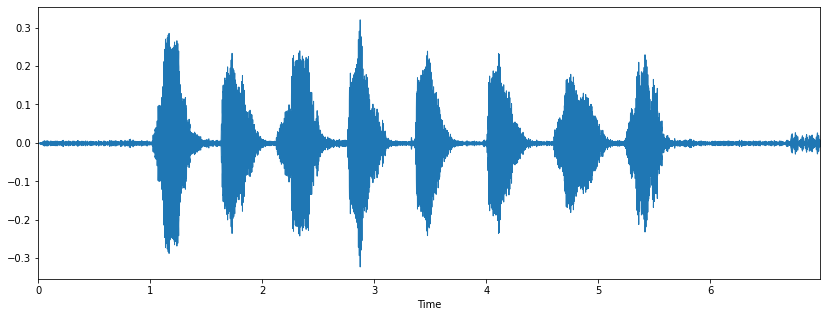

In [4]:
# Загрузим один из файлов
wav, sr = librosa.load("waves_yesno/0_1_0_1_1_1_0_0.wav")
draw_waveform(wav, sr)
ipd.Audio(wav, rate=sr)

Как можно услышать, в этом датасете произносятся какие-то два слова (yes/no на иврите). Каждый файл состоит из 8 произнесений. Метки слов указаны в названиях файлов.

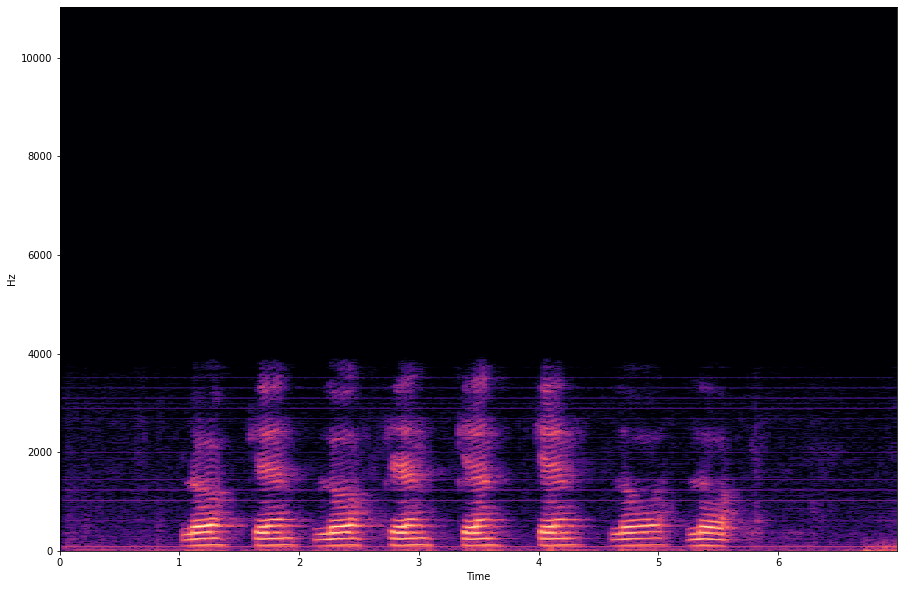

In [5]:
# Построим спектрограмму загруженной вавки
stft = librosa.stft(wav)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(15,10))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')

# Задание 0.1: Анализ спектрограммы (0.5 балла)
1. Посмотрите на спектрограмму и попробуйте найти признаки, по которым можно отличить произнесение "yes" от "no". 
1. В каких частотах находится основная энергия этого речевого сигнала? 

1. -
2. -

# Задание 1: Мел-шкала (1 балл)
Нарисовать спектрограму в [mel-шкале](https://en.wikipedia.org/wiki/Mel_scale). 
Использовать формулу, представленную Дугласом О'Шонесси.

In [6]:
def mel(spec):
    #spec - stft spectrogra
    return np.array(2595 * np.log10(1 + spec/700))


In [7]:
def test_mel():
    x = np.random.randint(100, size=(1000, 100))
    x_mel = mel(x)
    x_hz = 700.0 * (10.0 ** (x_mel / 2595.0) - 1.0)
    assert np.allclose(x, x_hz), "TEST Hertz -> Mel -> Hertz  failed. "
test_mel()

# Мел-фильтры
Одними из наиболее популярных акустических признаков являются Filter Banks (fbanks). 
fbanks вычисляются применением нескольких (количество фильтров = количество fbanks) треугольных фильтров к мел-спектрограмме. Чтобы не делать два действия со спектрограммой, переход к мел-шкале и применение фильтров в мел-шкале можно заменить на перевод мел-фильтров в Герц-шкалу и применение их к Герц-спектрограмме.



# Задание 2 (3 балла)
Реализуйте функцию вычисления fbank. 

непонятно как именно нормализуются треугольники в либросе (использовал нормализацию о которой они пишут в документации помогло только частично) поэтому идеального совпадения не смог добиться

In [8]:
def f(k, m, line, norm='slaney'):
    if norm == 'slaney':
        C = (2/(line[m+1]-line[m-1]))
    else:
        C = 1
    if k < line[m-1]:
        return 0
    elif line[m-1] <= k and k <= line[m]:
        return (k - line[m-1]) / (line[m]-line[m-1]) * C
    elif line[m] <= k and k <= line[m+1]:
        return (line[m+1]- k) / (line[m+1] - line[m]) * C
    else:
        return 0
def mel_filters(sr, n_fft, n_mels, norm='slaney'):
    # функция построения треугольных мел-фильтров в герц-шкале
    # sr - sample rate
    # n_fft - length of the FFT window 
    # n_mels - number of filters
    # return mel filters matrix. [n_mel, n_fft]
    n_fft = n_fft//2+1
    start_mel = mel(sr/n_fft)
    end_mel = mel(sr/n_fft*n_fft)
    line_mel = np.linspace(start_mel, end_mel, n_mels+2)
    line_hz = 700.0 * (10.0 ** (line_mel / 2595.0) - 1.0)
    line = line_hz // (sr/n_fft)
    out = []
    for i in range(1, n_mels+1):
        outn = [f(k, i, line, norm) for k in range(n_fft)]
        out.append(outn)
    return np.array(out)
    return librosa.filters.mel(sr, n_fft, n_mels=n_mels)
m = mel_filters(32, 46, 4)

(40, 257)


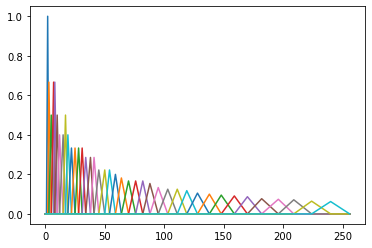

In [9]:
m1 = mel_filters(8600, 512, 40)
print(m1.shape)
for i in m1: 
    plt.plot(i)
plt.show()

(40, 257)


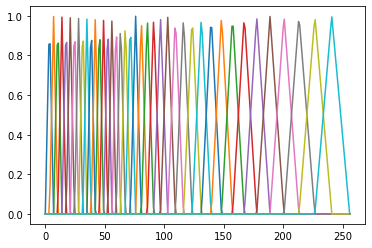

(array([ 0,  0,  0, ..., 39, 39, 39]),
 array([  0,   8,   9, ..., 225, 226, 256]))

In [10]:

m = librosa.filters.mel(8600, 512, 40, norm=None)
print(m.shape)
for i in m: 
    plt.plot(i)
plt.show()
np.where(m==0)

In [11]:
assert mel_filters(32, 46, 4).shape == (4, 24) and mel_filters(65, 45, 5).shape == (5, 23), "Wrong shape"
assert np.allclose(mel_filters(16, 8, 4), librosa.filters.mel(16, 8, n_mels=4))
assert np.allclose(mel_filters(8600, 512, 40), librosa.filters.mel(8600, 512, n_mels=40))
print("All ok!")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


AssertionError: ignored

In [12]:
def get_magnitude_from_spec(spec):
    return np.abs(spec)

def STFT(x, n_fft=2048, hop_length=512, window='hann'):
    #  Short-time Fourier transform
    # x - signal
    # n_fft - fft window size 
    # hop_length - step size between ffts
    # window - window type. See scipy.signal.get_window
    # return spectrogram

    T = len(x)//hop_length+1
    window = scipy.signal.get_window(window, n_fft)
    out = []
    pad_width = n_fft//2 + (n_fft%2>0)
    x = np.pad(x, pad_width=pad_width, mode='reflect')
    for i in range(T):
        xi = x[i*hop_length :i*hop_length+n_fft]
        outn = xi*window
        outn = np.fft.fft(outn)[:len(outn)//2+1]
        out.append(outn)

    return np.transpose(np.array(out))

даже используя функции либросы не получается добиться исходного результата, даже если скопировать код с их гита (хотя они его, вроде, обновляют)

In [14]:

def get_fbanks(wav: np.ndarray, sr: int, window_ms=25, step_mc=10, n_fbanks=40):
    # wav - input signal
    # sr - sample rate
    # window_ms - window length in milliseconds
    # step_ms - stft step in milliseconds
    # n_fbanks - number of filters
    # return fbank matrix [n_fbanks, time]
    n_fft = window_ms * sr//1000
    hop_length = step_mc*sr//1000
    # steps_n = len(wav)//step_len + (len(wav)%step_len > 0)
    # for i in range(steps_n):
    #     i*=step_len
    #     window_wav = np.pad(wav[i:i+window_len], [0, window_len])[:window_len]
    stft = STFT(wav, n_fft, hop_length)
    stft = np.abs(librosa.stft(wav, n_fft, hop_length))
    fb = mel_filters(sr, n_fft, n_fbanks)
    fb = librosa.filters.mel(sr, n_fft, n_fbanks)
    out = []
    for window in stft.transpose():
        line = []
        for f in fb:
            line.append(np.sum(window*f))
        out.append(line)
    return np.array(out).transpose()


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

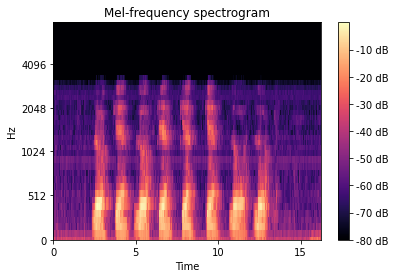

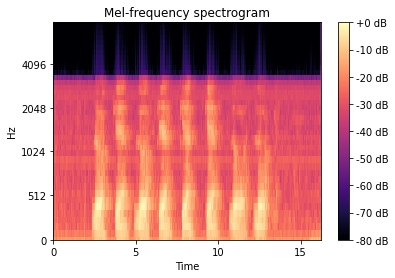

In [15]:
import matplotlib.pyplot as plt
window_ms=25
step_mc=10
n_fbanks=40
n_fft = window_ms * sr//1000
hop_length = step_mc * sr//1000

S = librosa.feature.melspectrogram(wav, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_fbanks)
S1 = get_fbanks(wav, sr, window_ms=window_ms, step_mc=step_mc, n_fbanks=n_fbanks)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

fig, ax = plt.subplots()
S_dB1 = librosa.power_to_db(S1, ref=np.max)
img = librosa.display.specshow(S_dB1, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [16]:
def test_fbank(wav, sr, window_ms=25, step_mc=10, n_fbanks=40):
    n_fft = window_ms * sr//1000
    hop_length = step_mc * sr//1000
    fbanks_lib = librosa.feature.melspectrogram(wav, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_fbanks)
    fbanks = get_fbanks(wav, sr, window_ms=window_ms, step_mc=step_mc, n_fbanks=n_fbanks)
    
    if fbanks_lib.shape != fbanks.shape:
        print("TEST FAILED")
        print(f"Shape {fbanks_lib.shape} != {fbanks.shape}")
    if not np.allclose(fbanks_lib, fbanks):
        print("TEST FAILED")
        print(f"Average diff is {np.mean(np.abs(fbanks_lib - fbanks))}")
        return -1
    print("TEST PASSED")
    return 0
assert test_fbank(wav[:sr*1], sr) == 0, "1 sec wav test failed" #0.02661267287601993
assert test_fbank(wav, sr) == 0 , "All wav test failed" #0.029360665008425713
print("All ok!")

TEST FAILED
Average diff is 0.0004812526749446988


AssertionError: ignored

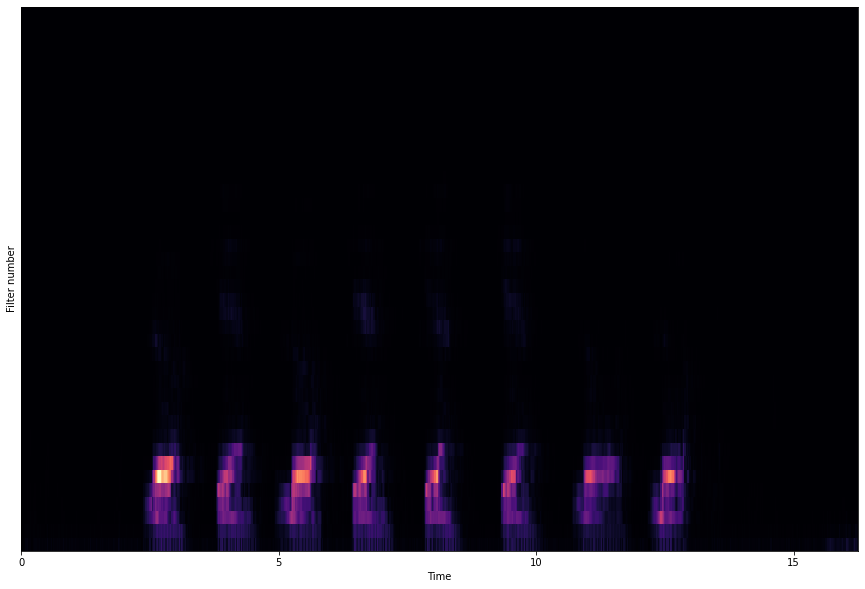

In [17]:
fbanks = get_fbanks(wav, sr)
plt.figure(figsize=(15,10))
librosa.display.specshow(fbanks, sr=sr, x_axis='time')
plt.ylabel("Filter number")
plt.show()

# Задание 4 (3 балла)
Реализовать вычисление [mfcc](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)



In [54]:
def get_mfcc(wav: np.ndarray, sr: int, window_ms=25, step_mc=10, n_mfcc=13):
      # wav - input signal
    # sr - sample rate
    # window_ms - window length in milliseconds
    # step_ms - stft step in milliseconds
    # n_mfcc - number of filters
    # return mfcc matrix [n_mfcc, time]
    
    # YOUR CODE HERE
    x = get_fbanks(wav, sr, window_ms=window_ms, step_mc=step_mc)[:n_mfcc]
    x = np.log10(x)
    x = scipy.fftpack.dct(x, type=2, axis=0, norm='ortho')
    #
    return x

[Text(0.5, 1.0, 'MFCC')]

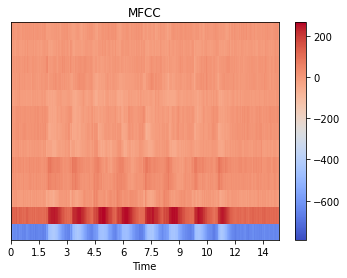

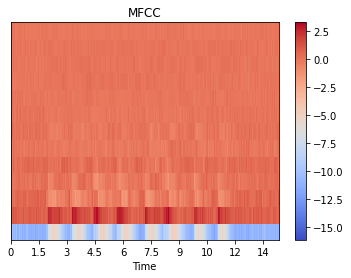

In [55]:
import matplotlib.pyplot as plt
window_ms=25
step_mc=10
n_mfcc=13
n_fft = window_ms * sr//1000
hop_length = step_mc * sr//1000

mfcc = get_mfcc(wav, sr, window_ms=window_ms, step_mc=step_mc, n_mfcc=n_mfcc)
mfcc_lib = librosa.feature.mfcc(wav, sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
fig, ax = plt.subplots()
img = librosa.display.specshow(mfcc_lib, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

fig, ax = plt.subplots()
img = librosa.display.specshow(mfcc, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

In [20]:
def test_mfcc(wav, sr, window_ms=25, step_mc=10, n_mfcc=13):
    n_fft = window_ms * sr//1000
    hop_length = step_mc * sr//1000
    mfcc_lib = librosa.feature.mfcc(wav, sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
    mfcc = get_mfcc(wav, sr, window_ms=window_ms, step_mc=step_mc, n_mfcc=n_mfcc)
    
    if mfcc_lib.shape != mfcc.shape:
        print("TEST FAILED")
        print(f"Shape {mfcc_lib.shape} != {mfcc.shape}")
    if not np.allclose(mfcc_lib, mfcc):
        print("TEST FAILED")
        print(f"Average diff is {np.mean(np.abs(mfcc_lib - mfcc))}")
        return -1
    print("TEST PASSED")
    return 0
assert test_mfcc(wav[:sr*1], sr) == 0, "1 sec wav test failed" #92.76535034179688
assert test_mfcc(wav, sr) == 0 , "All wav test failed" #63.17601013183594
print("All ok!")

TEST FAILED
Average diff is 67.51309967041016


AssertionError: ignored

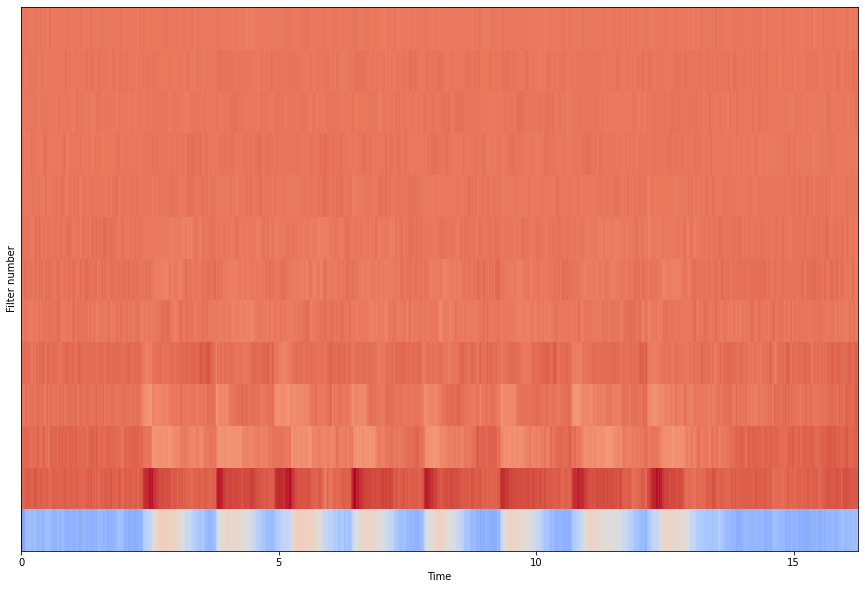

In [21]:
mfcc = get_mfcc(wav, sr)
plt.figure(figsize=(15,10))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.ylabel("Filter number")
plt.show()

# Классификация слов
Построим простую систему, классифицирующую слова yes/no.

Загрузим весь датасет

In [22]:
def load_yn_dataset(directory):
    X, labels = [], []
    bad_files = set(["0_1_0_1_0_0_0_0"])
    for f in glob(directory +"/*.wav"):
        name = os.path.basename(f)[:-4]
        if name in bad_files:
            continue
        y = [int(l) for l in name.split("_")]
        x, _ = librosa.load(f)
        X.append(x)
        labels.append(y)
        
    return X, labels
        
X, Y = load_yn_dataset("waves_yesno/")

Отделим 20% для теста

In [23]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y,test_size=0.2, random_state=1)

# Задание *5 (1 балл)
Voice Activity Detector (VAD) определяет, есть ли речь в текущем кадре.
Реализуйте простой VAD. Настройте VAD, чтобы хорошо определялись границы слов.

Подсказка:
Можно отличать паузу от речи по энергии mfcc спектра( или части спектра). Чтобы предотвратить скачки на краях слов, воспользуйтесь сверткой со сглаживающим окном, например, Ханна.

использовал методы из либросы вместо тех что реализованы в лабах т.к. накопилось много расхождений + слабая оптимизация

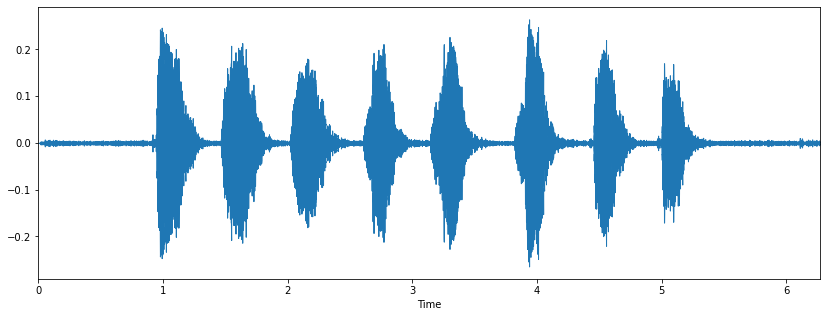

In [36]:
wav, sr = librosa.load("waves_yesno/1_0_0_0_0_0_1_1.wav")
draw_waveform(wav, sr)
ipd.Audio(wav, rate=sr)

[Text(0.5, 1.0, 'MFCC')]

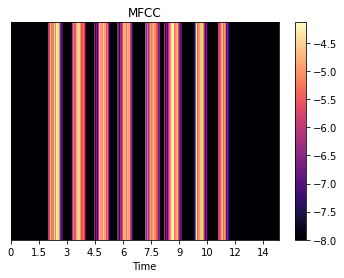

In [56]:
import matplotlib.pyplot as plt
#mfccs = librosa.feature.mfcc(wav)[:6, :]
mfccs = get_mfcc(wav, sr)[:6, :]

mfccs = np.expand_dims(np.apply_along_axis(sum, axis=0, arr=mfccs), axis=0)
mfccs = np.where(mfccs[0] > -8, mfccs, [-8])
# mfccs
fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')


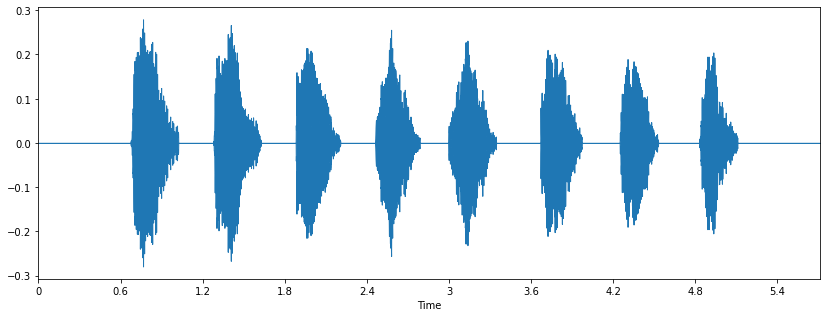

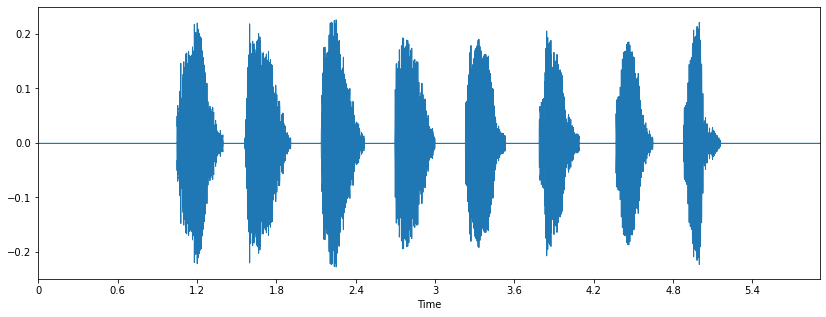

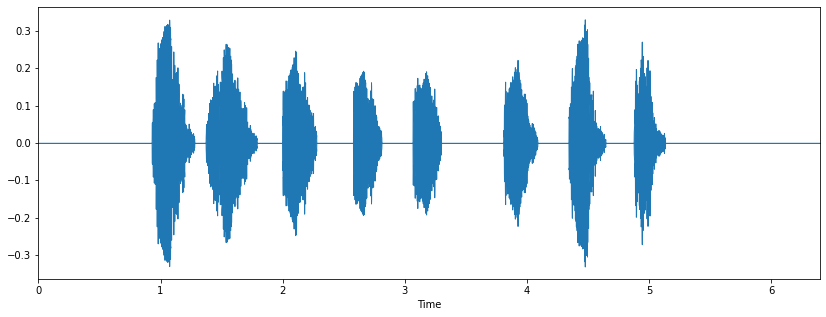

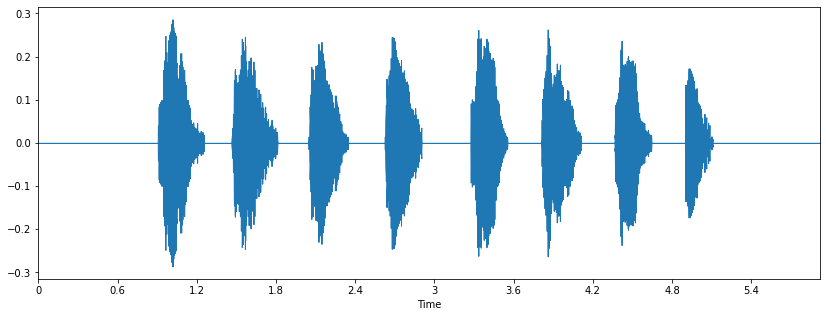

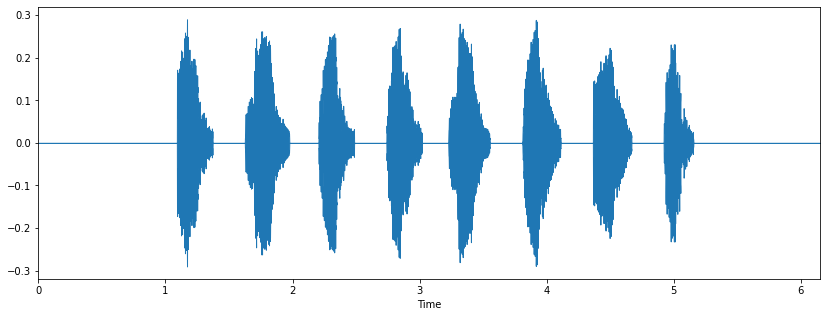

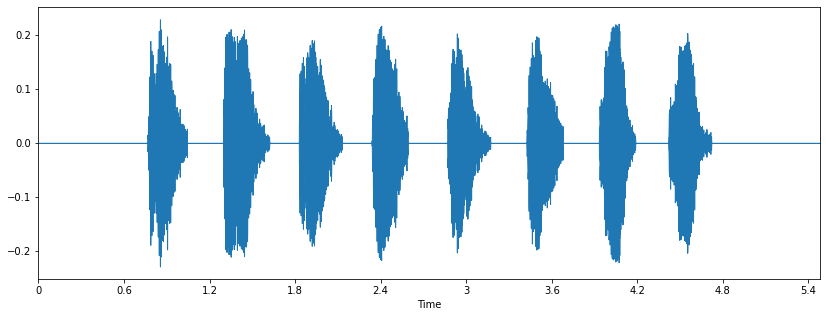

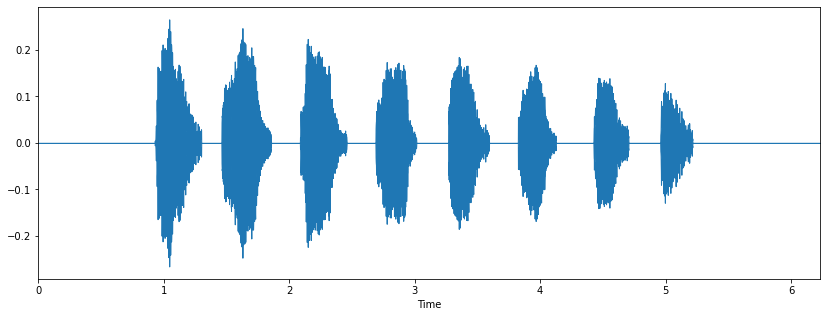

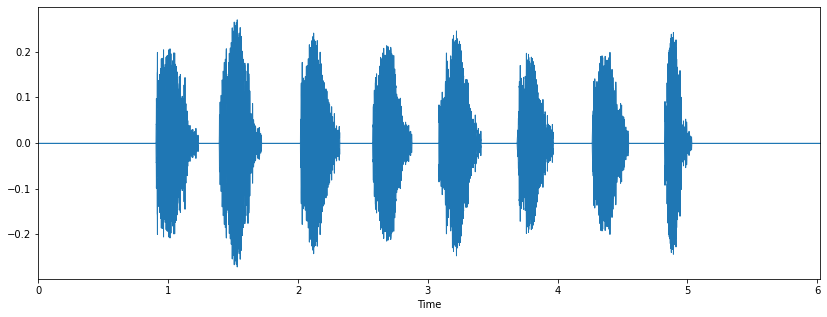

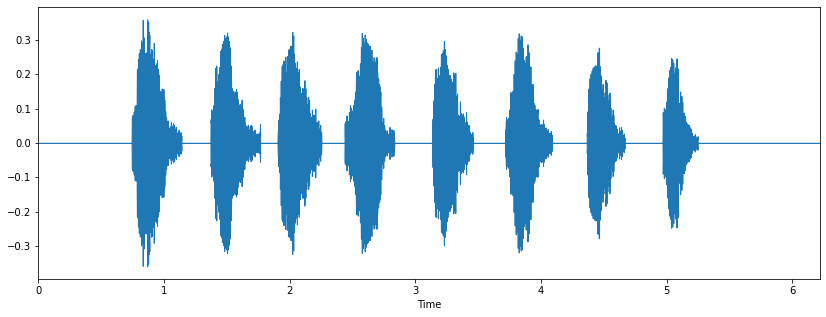

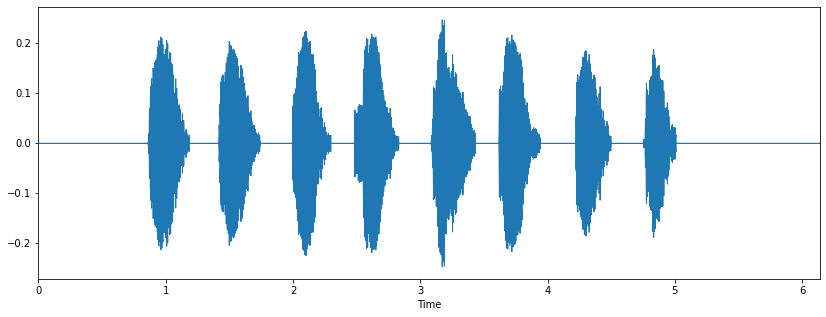

In [66]:
# YOUR CODE HERE

def silence_masking(wav, th=170):
    mfccs = librosa.feature.mfcc(wav)[1:2, :]
    mfcc_mask = np.where(sum(mfccs) > th, 1, 0)
    C = len(wav)//len(mfcc_mask)+(len(wav)%len(mfcc_mask)>0)
    wav_mask = []
    for m in mfcc_mask:
        x = [m for _ in range(C)]
        #print(len(x))
        wav_mask += x
    return np.array(wav_mask[:len(wav)])

for i in range(10):
    wav = X_train[i]
    mask = silence_masking(wav)
    draw_waveform(wav*mask, sr)
    display(ipd.Audio(wav*mask, rate=sr))

In [39]:
train_VA = list(map(lambda x: silence_masking(x, th=170), X_train))# List[np.ndarray]. 1 - Voice, 0 - silence 
test_VA = list(map(lambda x: silence_masking(x, th=170), X_test))# List[np.ndarray]. 1 - Voice, 0 - silence 

In [40]:
def test_VAD(VA, Y, min_acc=0.95):
    print(Y)
    print(VA)
    def check_ali(ali, num_words):
        diff = ali[1:]  - ali[:-1]
        if diff.sum()!=0:
            print("VAD detected speech at the beginning (or end) of audio")
            return -1 
        if not (diff > 0).sum() == (diff > 0).sum() ==  num_words:
            return -2
        return 0
    
    bad_i = []
    err =0
    for i, (ali, y) in enumerate(zip(VA, Y)):
        if check_ali(ali, len(y)) != 0:
            bad_i.append(i)
            err+=1
    acc = (len(Y) - err)/len(Y)
    print(f"Accuracy {acc}")
    if len(bad_i) >0:
        print(f"ids with error {bad_i}")
    assert acc >= min_acc , f"Accuracy must be >= {min_acc}"
    print("Test passed")

test_VAD(train_VA, Y_train)
test_VAD(test_VA, Y_test)
print("VAD ok!")

[[1, 1, 1, 0, 0, 1, 1, 1], [0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 1, 1, 1, 0, 0, 1], [0, 1, 1, 1, 0, 1, 0, 1], [1, 0, 0, 1, 0, 1, 1, 1], [1, 1, 0, 1, 0, 1, 0, 0], [1, 0, 0, 0, 1, 0, 0, 1], [0, 0, 1, 0, 0, 1, 1, 0], [0, 0, 1, 0, 1, 0, 0, 0], [1, 1, 0, 0, 1, 0, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 0, 1, 0, 1, 0], [1, 1, 1, 0, 1, 0, 1, 1], [0, 0, 1, 1, 0, 1, 0, 0], [1, 1, 0, 0, 1, 0, 1, 0], [0, 0, 1, 1, 1, 1, 0, 0], [0, 0, 1, 0, 0, 0, 1, 0], [1, 1, 0, 1, 1, 1, 1, 0], [1, 0, 1, 1, 1, 0, 1, 0], [0, 1, 1, 1, 1, 0, 1, 0], [0, 1, 0, 0, 1, 0, 1, 1], [0, 1, 0, 0, 1, 0, 1, 0], [1, 0, 0, 0, 0, 0, 0, 1], [0, 0, 1, 1, 1, 0, 0, 0], [0, 0, 0, 0, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 0, 1, 1, 0, 1, 0], [0, 0, 1, 1, 1, 1, 1, 0], [0, 1, 0, 0, 0, 1, 1, 0], [1, 0, 1, 1, 0, 1, 1, 1], [1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 0, 0, 1, 0], [1, 1, 1, 1, 1, 0, 0, 0], [0, 1, 1, 1, 0, 0, 1, 0], [0, 0, 1, 1, 0, 0, 0, 1], [1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 0, 0, 0, 1, 1, 1], [0, 0, 1, 1, 0, 1, 1, 1], [1, 1, 0, 1

# Задание *6 (2 балла)
Обучите классификатор, определяющий, какое слово было сказано. Используйте VAD для разбиения входных файлов на отдельные слова. Классификацию можно сделать, например, с помощью SVM по усредненным признаки выделеных VAD'ом слов. Или любым другим удобным для вас способом. Добейтесь точности больше 0.95

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [30]:
def wav_proc(wav, pad_size=10000):
    try:
        y = wav[1]
        wav = wav[0]
        mask = silence_masking(wav, th=170)
        v=[1,-1]
        se_mask = np.abs(np.convolve(mask, v, 'same'))
        se_points = np.reshape(np.where(se_mask == 1), (8, 2))
        words=[]
        for start, end in se_points:
            sample = np.pad(wav[start:end],(0,pad_size))[:pad_size]
            #sample = wav[start:end]
            words.append(sample)
        # y = np.reshape(y, (1, 8))
        return np.array(words), y
    except ValueError:
        print('skeep')


In [31]:
train_list = list(map(wav_proc, zip(X_train, Y_train)))
x_train = np.concatenate([np.expand_dims(i[0], axis=1) for i in train_list if i])
y_train = np.concatenate([i[1] for i in train_list if i])

test_list = list(map(wav_proc, zip(X_test, Y_test)))
x_test = np.concatenate([np.expand_dims(i[0], axis=1) for i in test_list if i])
y_test = np.concatenate([i[1] for i in test_list if i])

x_train.shape, y_train.shape, x_test.shape, y_test.shape

skeep
skeep


((360, 1, 10000), (360,), (96, 1, 10000), (96,))

In [32]:
class M5(nn.Module):
    def __init__(self, n_input, n_output=2, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)
    
    def train_model(self, x_train, y_train, optimizer, scheduler, b_size=32, epoch=1):
        model = self
        model.train()
        for e in range(epoch):
            losses = []
            x_batch = []
            y_batch = []
            for batch_idx, (x, y) in enumerate(zip(x_train, y_train)):
                x_batch.append(x)
                y_batch.append(y)

                if len(x_batch)==b_size:
                    x_batch = np.array(x_batch)
                    y_batch = np.array(y_batch)

                    data = torch.tensor(x_batch).to(device)
                    target = torch.tensor(y_batch).to(device)

                    output = model(data)

                    loss = F.nll_loss(output.squeeze(), target)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    losses.append(loss.item())

                    x_batch = []
                    y_batch = []
            scheduler.step()
            print('epoch: ', e, np.mean(losses))
        
    def test(self, x_test, y_test, metric):
        model = self
        model.eval()
        test_sample = torch.tensor(x_test)
        test_target = y_test
        out = model(test_sample)
        y_true = test_target
        y_pred = out.argmax(dim=-1).squeeze(1).numpy()
        print(y_true - y_pred)
        return metric(y_true, y_pred)
    
    def predict(self, wav):
        model = self
        model.eval()
        test_sample = torch.tensor([wav])
        out = model(test_sample)
        y_pred = out.argmax(dim=-1).squeeze(1).numpy()
        if y_pred:
            return 'yes'
        else:
            return 'no'

In [33]:
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = M5(n_input=x_train.shape[1], n_output=2)#y_train.shape[0])
model.to(device)
print(model)

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

model.train_model(x_train, y_train, epoch=6, optimizer=optimizer, scheduler=scheduler)
model.test(x_test, y_test, accuracy_score)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=2, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch:  0 0.2866657508367842
epoch:  1 0.06815844046121294
epoch:  2 0.028686918995597145
epoch:  3 0.013293102997439828
epoch:  4 0.004279346041254361
epoch:  5 0.0014833927535536614
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 -1  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


0.96875

predict: no target: no


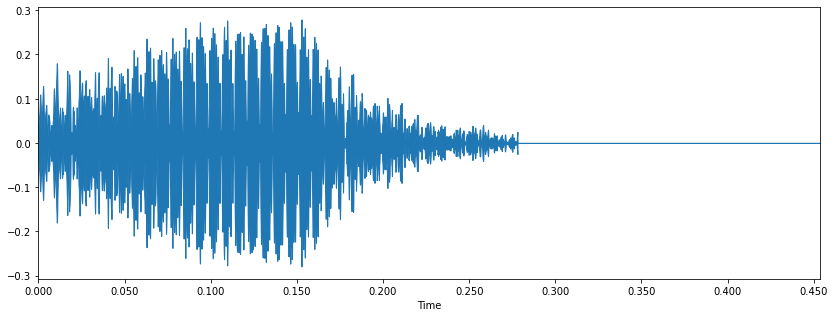

predict: no target: no


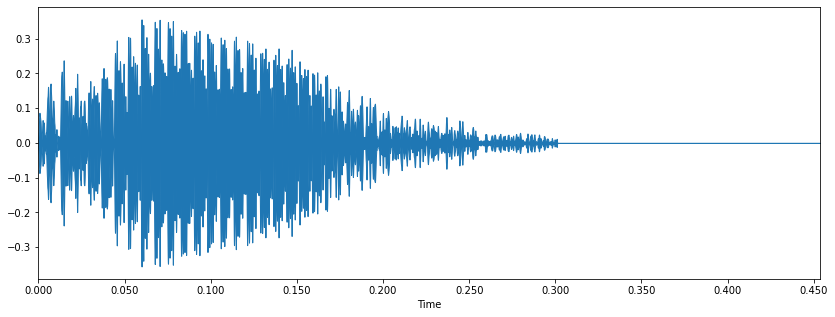

predict: yes target: yes


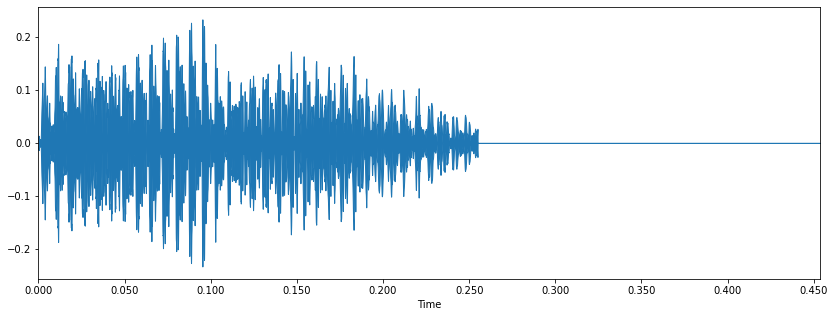

predict: no target: no


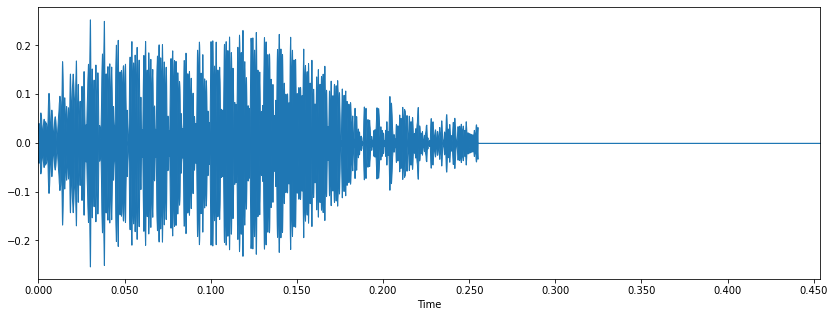

predict: no target: no


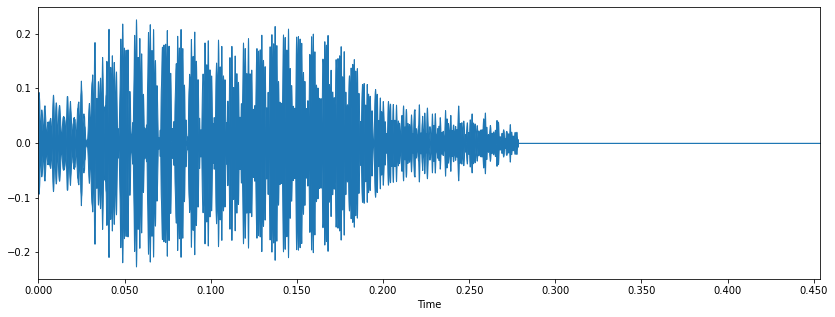

predict: yes target: yes


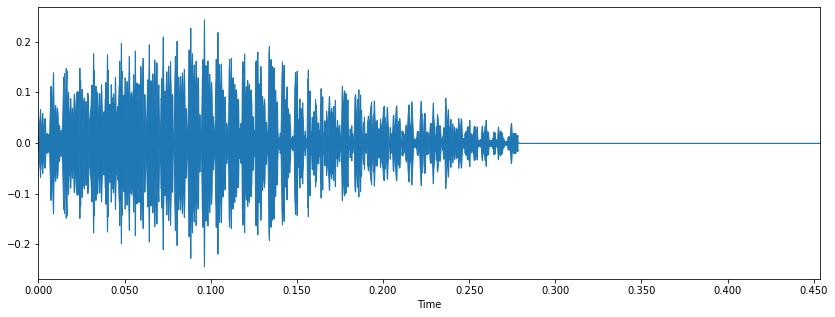

predict: yes target: yes


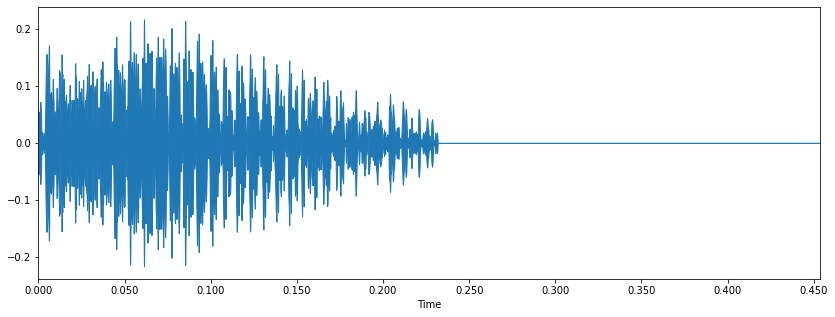

predict: yes target: yes


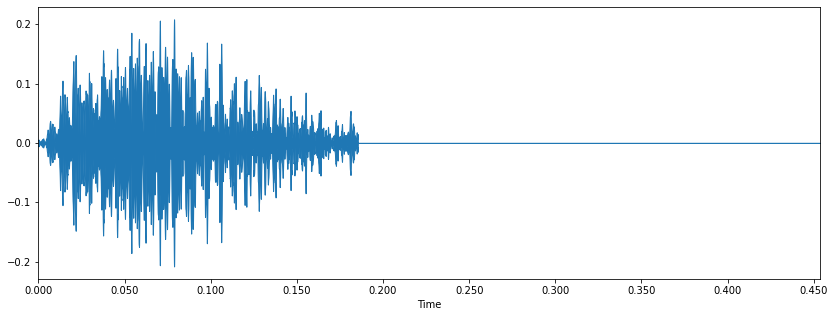

predict: no target: no


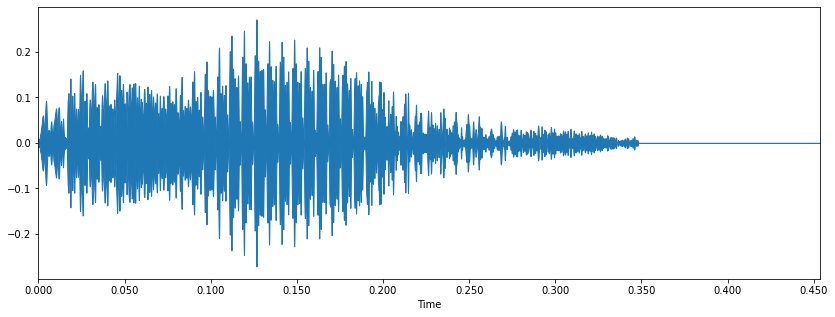

predict: yes target: yes


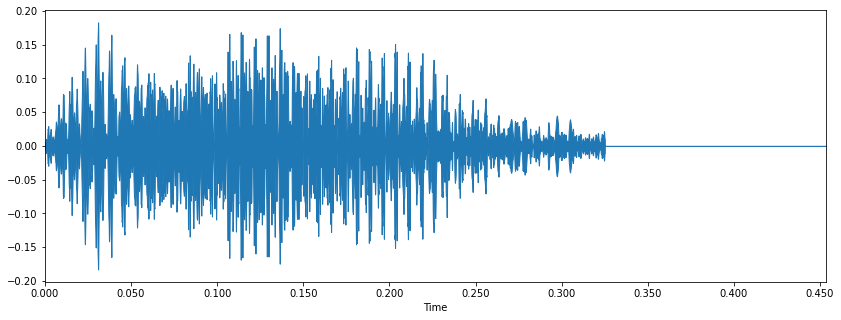

In [34]:
for i in range(10):
    wav = x_test[i]
    if y_test[i]:
        answer = 'yes'
    else:
        answer = 'no'
    print('predict:', model.predict(wav), 'target:', answer)
    draw_waveform(wav[0], sr)
    display(ipd.Audio(wav, rate=sr))